# Classification problem

In [1]:
import numpy as np
import pandas as pd

# VISUALIZATIONS
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

#SCIPY
from scipy import stats

# STATSMODELS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.mosaicplot import mosaic

# SKLEARN
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    PowerTransformer,
    RobustScaler,
    MinMaxScaler,
    LabelEncoder
)
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    SelectFromModel,
    SelectKBest,
    f_classif,
    mutual_info_classif,
    RFE
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
)
from sklearn.metrics import (
    average_precision_score,
    balanced_accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# GRADIENT BOOSTING
import xgboost as xgb
import catboost as ctb

# CATEGORY ENCODERS
from category_encoders import (
    CatBoostEncoder,
    WOEEncoder,
    OneHotEncoder,
    OrdinalEncoder
)

# HYPERPARAMETER OPTIMIZATION
import optuna as opt
from optuna.integration import OptunaSearchCV

# TREATING IMBALANCE
import imblearn

# EXPLAINABLE AI WITH SHAPLEY VALUES
import shap

## SEDA

### Investigating the dataset and initial preprocessing

In [2]:
credit_train = pd.read_csv("data/client_attrition_train.csv")

In [3]:
credit_train.sample(10)

customer_id  customer_age customer_sex  customer_number_of_dependents  \
1755        739927          36.0            M                              2   
8142        696240          50.0            F                              2   
4904        282922          38.0            M                              3   
8979        406470          55.0            F                              2   
1155        704873          42.0            F                              3   
1023        428865          44.0            F                              3   
6901        768833          26.0            F                              0   
10071       485283          42.0            F                              5   
6963        386710          37.0            F                              3   
2178        644529          45.0            F                              4   

      customer_education customer_civil_status customer_salary_range  \
1755            Graduate               Married                60-80K   
8142             College              Divorced             below 40K   
4904          Uneducated                Single                60-80K   
8979             Unknown                Single             below 40K   
1155            Graduate               Married             below 40K   
1023             College               Married                   NaN   
6901         High School                Single               Unknown   
10071            Unknown               Married             below 40K   
6963            Graduate                Single             below 40K   
2178         High School                Single               Unknown   

       customer_relationship_length  customer_available_credit_limit  \
1755                             17                           3092.0   
8142                             36                          31158.0   
4904                             31                          34516.0   
8979                             45                           3185.0   
1155                             36                           2526.0   
1023                             34                           3256.0   
6901                             13                           6152.0   
10071                            37                           2541.0   
6963                             24                           2802.0   
2178                             35                           8795.0   

      credit_card_classification  ...  period_inactive  contacts_in_last_year  \
1755                        Blue  ...                2                      3   
8142                        Blue  ...                2                      3   
4904                      Silver  ...                3                      2   
8979                        Blue  ...                2                      3   
1155                        Blue  ...                2                      2   
1023                        Blue  ...                1                      2   
6901                        Blue  ...                2                      4   
10071                       Blue  ...                2                      3   
6963                        Blue  ...                1                      4   
2178                        Blue  ...                4                      2   

       credit_card_debt_balance  remaining_credit_limit  \
1755                       1825                  1267.0   
8142                       1817                  1645.0   
4904                       1566                 32950.0   
8979                       1820                  1365.0   
1155                       2048                   478.0   
1023                       1013                  2243.0   
6901                          0                  6152.0   
10071                      1398                  1143.0   
6963                       2460                   342.0   
2178                       2517                  6278.0   

In [7]:
credit_train.shape

(10127, 21)

In [8]:
credit_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   customer_id                      10127 non-null  int64  
 1   customer_age                     9503 non-null   float64
 2   customer_sex                     9109 non-null   object 
 3   customer_number_of_dependents    10127 non-null  int64  
 4   customer_education               10127 non-null  object 
 5   customer_civil_status            10127 non-null  object 
 6   customer_salary_range            9446 non-null   object 
 7   customer_relationship_length     10127 non-null  int64  
 8   customer_available_credit_limit  10127 non-null  float64
 9   credit_card_classification       10127 non-null  object 
 10  total_products                   10127 non-null  int64  
 11  period_inactive                  10127 non-null  int64  
 12  contacts_in_last_y

In [12]:
print(f'''
Nulls make up the following percentage of these variables:
customer_age: {round((credit_train.customer_age.isnull().sum() * 100 / len(credit_train)), 2)}%
customer_sex: {round((credit_train.customer_sex.isnull().sum() * 100 / len(credit_train)), 2)}%
customer_salary_range: {round((credit_train.customer_salary_range.isnull().sum() * 100 / len(credit_train)), 2)}%
total_transaction_amount: {round((credit_train.total_transaction_amount.isnull().sum() * 100 / len(credit_train)), 2)}%
''')


Nulls make up the following percentage of these variables:
customer_age: 6.16%
customer_sex: 10.05%
customer_salary_range: 6.72%
total_transaction_amount: 4.02%



In [4]:
def get_cats(df):
    for col in ['customer_sex', 'customer_education', 'customer_civil_status', 'customer_salary_range', 'credit_card_classification', 'account_status']:
        df[col] = df[col].astype('category')

In [5]:
get_cats(credit_train)

Splitting the data early to simulate the production environment.

In [6]:
train_df, val_df = train_test_split(credit_train, test_size = 0.3, random_state = 1, stratify=credit_train['account_status'])

In [7]:
train_df = train_df.drop(['customer_id'], axis = 1)
val_df = val_df.drop(['customer_id'], axis = 1)

In [285]:
train_df.describe()

customer_age  customer_number_of_dependents  \
count   6643.000000                    7088.000000   
mean      46.401927                       2.339306   
std        7.999876                       1.297715   
min       26.000000                       0.000000   
25%       41.000000                       1.000000   
50%       46.000000                       2.000000   
75%       52.000000                       3.000000   
max       73.000000                       5.000000   

       customer_relationship_length  customer_available_credit_limit  \
count                   7088.000000                      7088.000000   
mean                      35.960920                     10076.439503   
std                        7.958444                     17495.849406   
min                       13.000000                      1438.300000   
25%                       32.000000                      2581.750000   
50%                       36.000000                      4725.500000   
75%                       40.000000                     11926.250000   
max                       56.000000                    310644.000000   

       total_products  period_inactive  contacts_in_last_year  \
count     7088.000000      7088.000000            7088.000000   
mean         4.136287         2.330841               2.446529   
std          3.095953         1.001563               1.105787   
min          1.000000         0.000000               0.000000   
25%          3.000000         2.000000               2.000000   
50%          4.000000         2.000000               2.000000   
75%          5.000000         3.000000               3.000000   
max         36.000000         6.000000               6.000000   

       credit_card_debt_balance  remaining_credit_limit  \
count               7088.000000             7088.000000   
mean                1165.150677             7532.002822   
std                  814.132570             9137.823158   
min                    0.000000                3.000000   
25%                  421.000000             1361.000000   
50%                 1278.500000             3503.000000   
75%                 1784.250000             9927.000000   
max                 2517.000000            34516.000000   

       transaction_amount_ratio  total_transaction_amount  \
count               7088.000000               6803.000000   
mean                   0.758258               5252.873732   
std                    0.217049               7570.862564   
min                    0.000000                510.000000   
25%                    0.629000               2171.500000   
50%                    0.736000               3956.000000   
75%                    0.858000               4813.000000   
max                    3.355000             117159.000000   

       total_transaction_count  transaction_count_ratio  average_utilization  
count              7088.000000              7088.000000          7088.000000  
mean                 64.578019                 0.812872             0.272614  
std                  23.373975                 0.589002             0.274420  
min                  10.000000                 0.000000             0.000000  
25%                  45.000000                 0.586750             0.023750  
50%                  67.000000                 0.710000             0.174000  
75%                  80.000000                 0.837000             0.499000  
max                 139.000000                 6.175000             0.999000

In [23]:
train_df.describe(include=['category'])

customer_sex customer_education customer_civil_status  \
count          6409               7088                  7088   
unique            2                  7                     4   
top               F           Graduate               Married   
freq           3366               2217                  3245   

       customer_salary_range credit_card_classification account_status  
count                   6621                       7088           7088  
unique                     6                          4              2  
top                below 40K                       Blue           open  
freq                    2326                       6606           5949

### Graph analysis

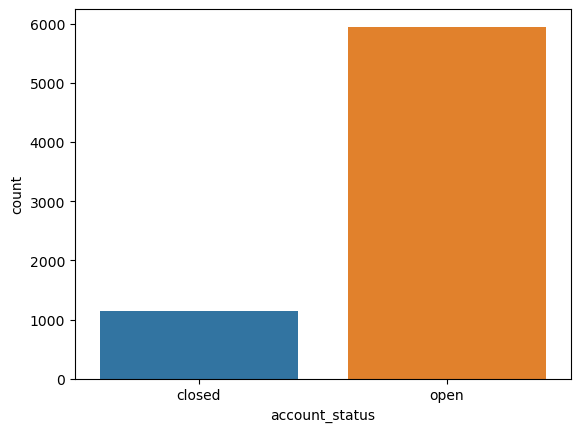

In [21]:
# Severe imbalance - the metric is balanced accuracy, but undersampling or oversampling could be used
sns.countplot(x=train_df['account_status'])
plt.show()

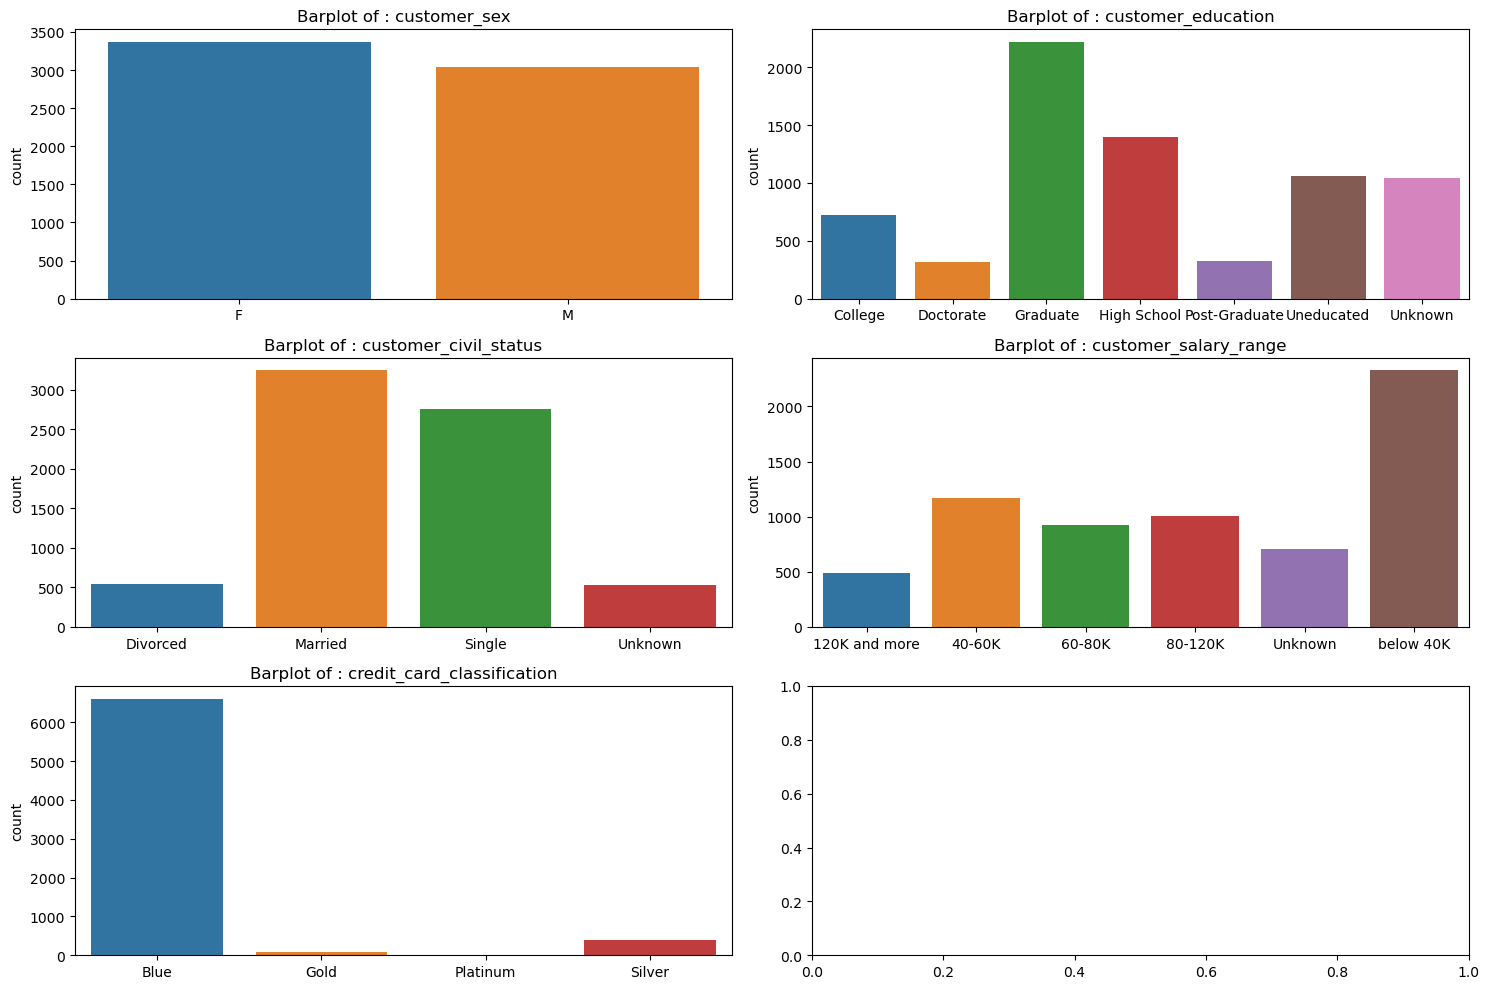

In [25]:
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (15, 10))

for i, ax in zip(list(train_df.drop(columns = ['account_status'], axis = 1).select_dtypes(include=['category']).columns), axes.flat):
    sns.countplot(data = train_df, x = i, ax=ax).set(title = f"Barplot of : {i}", xlabel = "")

plt.tight_layout()
plt.show()

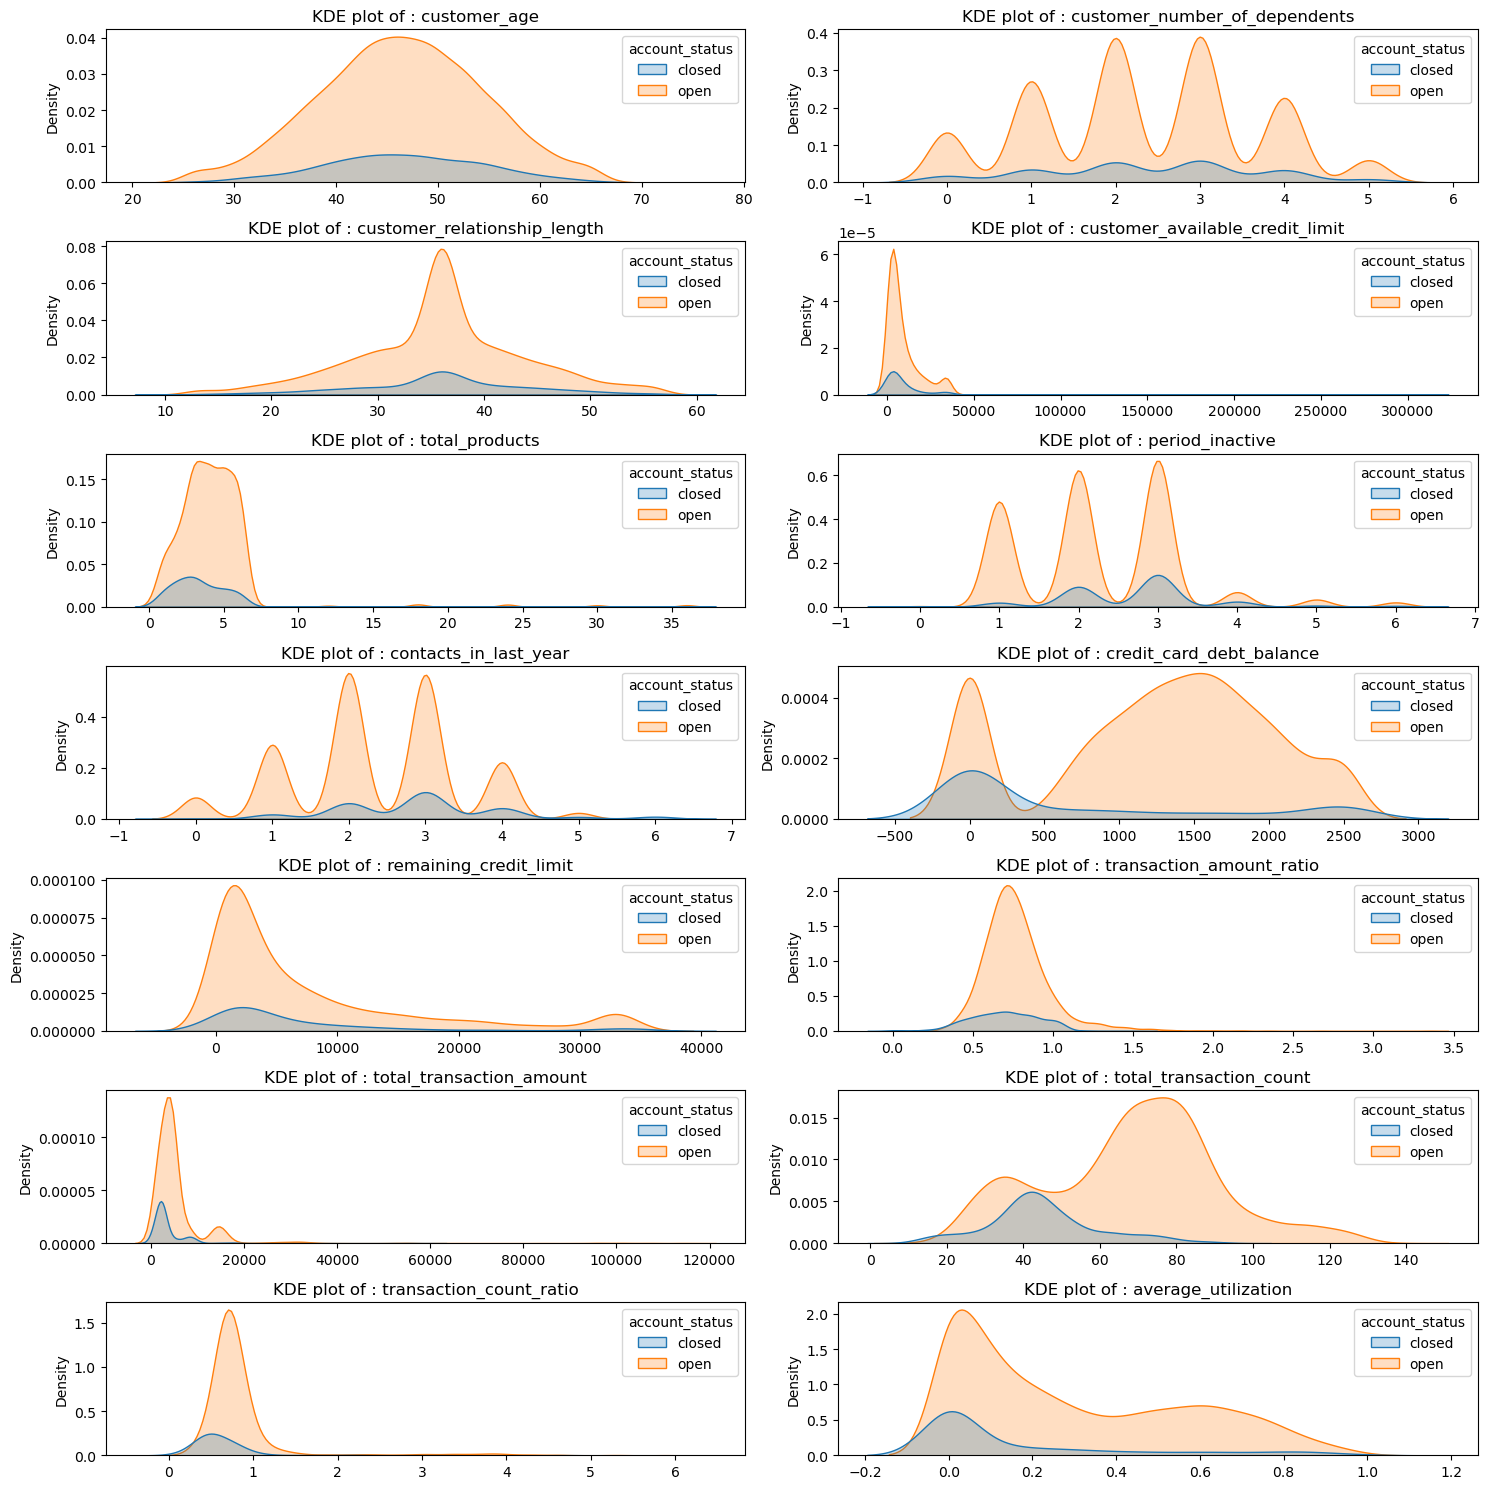

In [30]:
fig, axes = plt.subplots(ncols = 2, nrows = 7, figsize = (15, 15))

for i, ax in zip(list(train_df.select_dtypes(include=['float64', 'int64']).columns), axes.flat):
    sns.kdeplot(data = train_df, x = i, hue = 'account_status', ax = ax, fill = True).set(title = f"KDE plot of : {i}", xlabel = "")

plt.tight_layout()
plt.show()

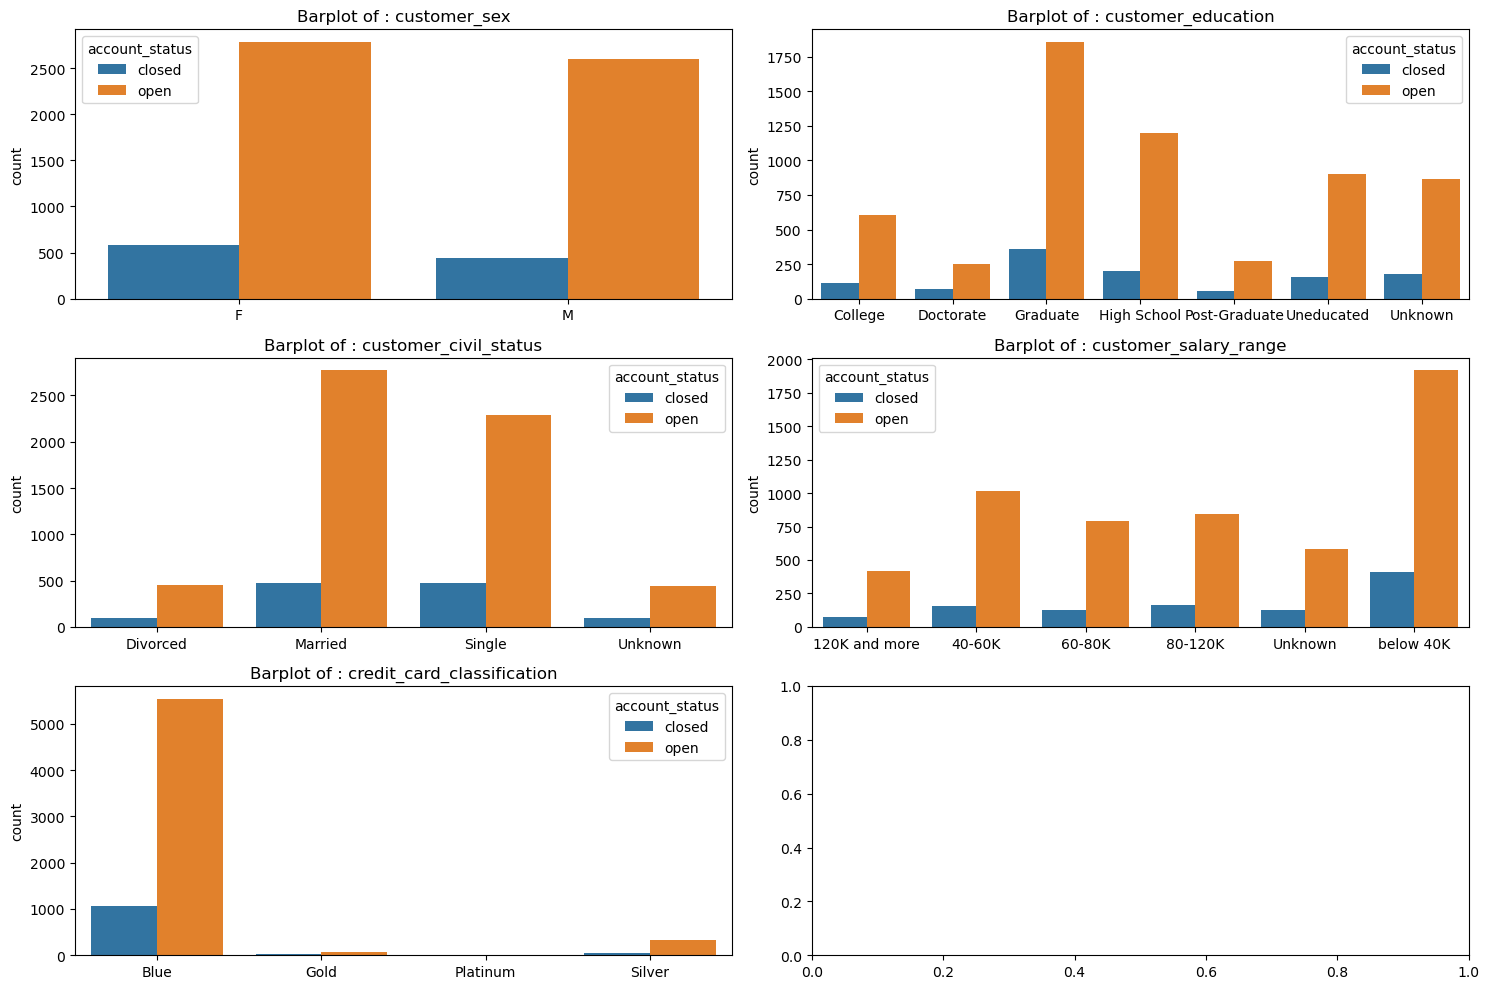

In [37]:
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (15, 10))

for i, ax in zip(list(train_df.drop(columns = ['account_status'], axis = 1).select_dtypes(include=['category']).columns), axes.flat):
    sns.countplot(data = train_df, x = i, hue = 'account_status', ax=ax).set(title = f"Barplot of : {i}", xlabel = "")

plt.tight_layout()
plt.show()

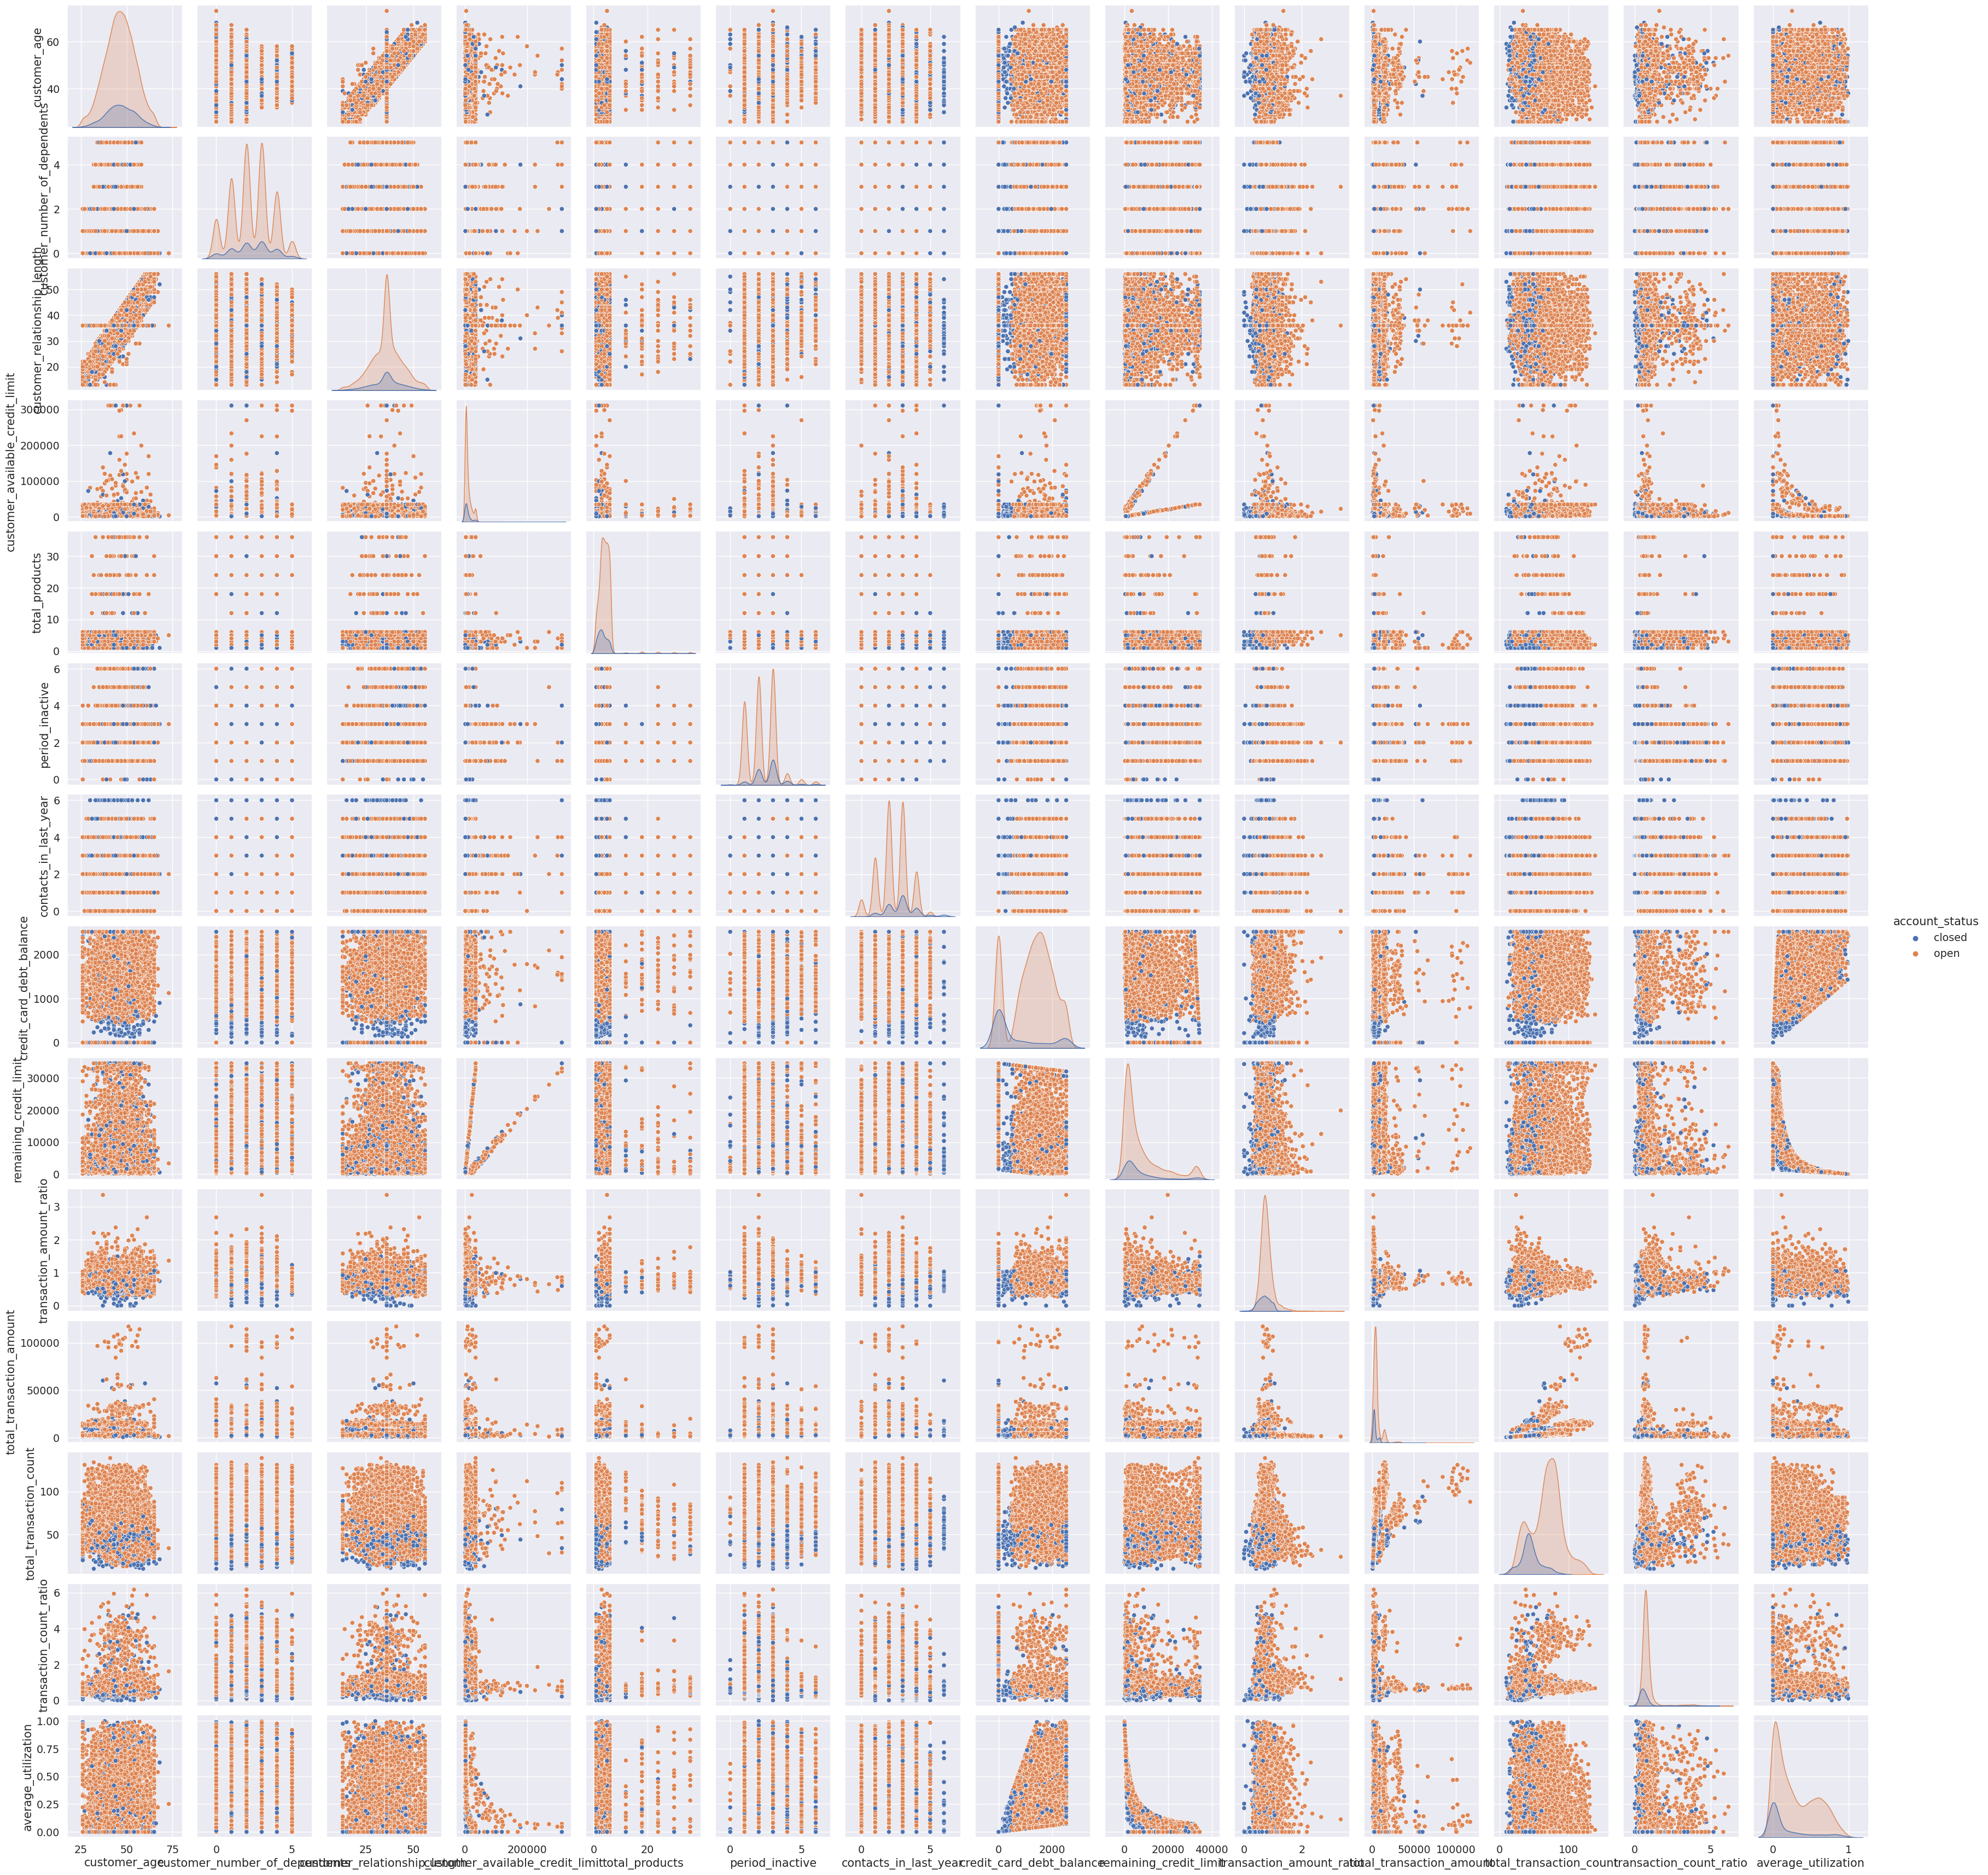

In [25]:
sns.pairplot(train_df, hue="account_status")
plt.show()

Based on the pairsplot, these float and integer features look promising:
* contacts_in_last_year
* credit_card_debt_balance
* total_transaction_count
* transaction_amount_ratio

### Statistical analysis

In [8]:
train_df['account_status'] = [1 if status == 'closed' else 0 for status in train_df.account_status]

train_df['account_status'] = train_df['account_status'].astype('boolean')

val_df['account_status'] = [1 if status == 'closed' else 0 for status in val_df.account_status]

val_df['account_status'] = val_df['account_status'].astype('boolean')

In [13]:
def chi2_test(df, feature1, feature2):   
    contingency_tab = pd.crosstab(index = df[feature1], columns = df[feature2])
    chi2_result = stats.chi2_contingency(contingency_tab)
    print(f"\nChi Square Test result between {feature1} and {feature2} variables.")
    print(chi2_result.pvalue)

def corr_heatmap(df, method='spearman'):
    corr = df.corr(method=method, numeric_only=True)

    plt.figure(figsize=(10,10))
    sns.set(font_scale=1.25)
    sns.heatmap(
        corr, linewidths=1.5, annot=True, square=True, fmt=".2f", annot_kws={"size": 10}
    )
    plt.show()

In [61]:
# Point biserial correlation
train_df[train_df.select_dtypes(include=['int64', 'float64']).columns].corrwith(train_df['account_status'].astype('float'), 
                                                                                method=stats.pointbiserialr).iloc[1,:].apply(lambda x: '%.3f' % x)

customer_age                       0.386
customer_number_of_dependents      0.138
customer_relationship_length       0.574
customer_available_credit_limit    0.124
total_products                     0.000
period_inactive                    0.000
contacts_in_last_year              0.000
credit_card_debt_balance           0.000
remaining_credit_limit             0.607
transaction_amount_ratio           0.000
total_transaction_amount           0.000
total_transaction_count            0.000
transaction_count_ratio            0.000
average_utilization                0.000
Name: 1, dtype: object

In [9]:
for col in ['customer_education', 'customer_sex', 'customer_salary_range', 'customer_civil_status', 'credit_card_classification']:
    chi2_test(train_df, col, 'account_status')


Chi Square Test result between customer_education and account_status variables.
0.04729035706933818

Chi Square Test result between customer_sex and account_status variables.
0.0029071966912353133

Chi Square Test result between customer_salary_range and account_status variables.
0.008117584106152972

Chi Square Test result between customer_civil_status and account_status variables.
0.03168949754879317

Chi Square Test result between credit_card_classification and account_status variables.
0.24903937679182814


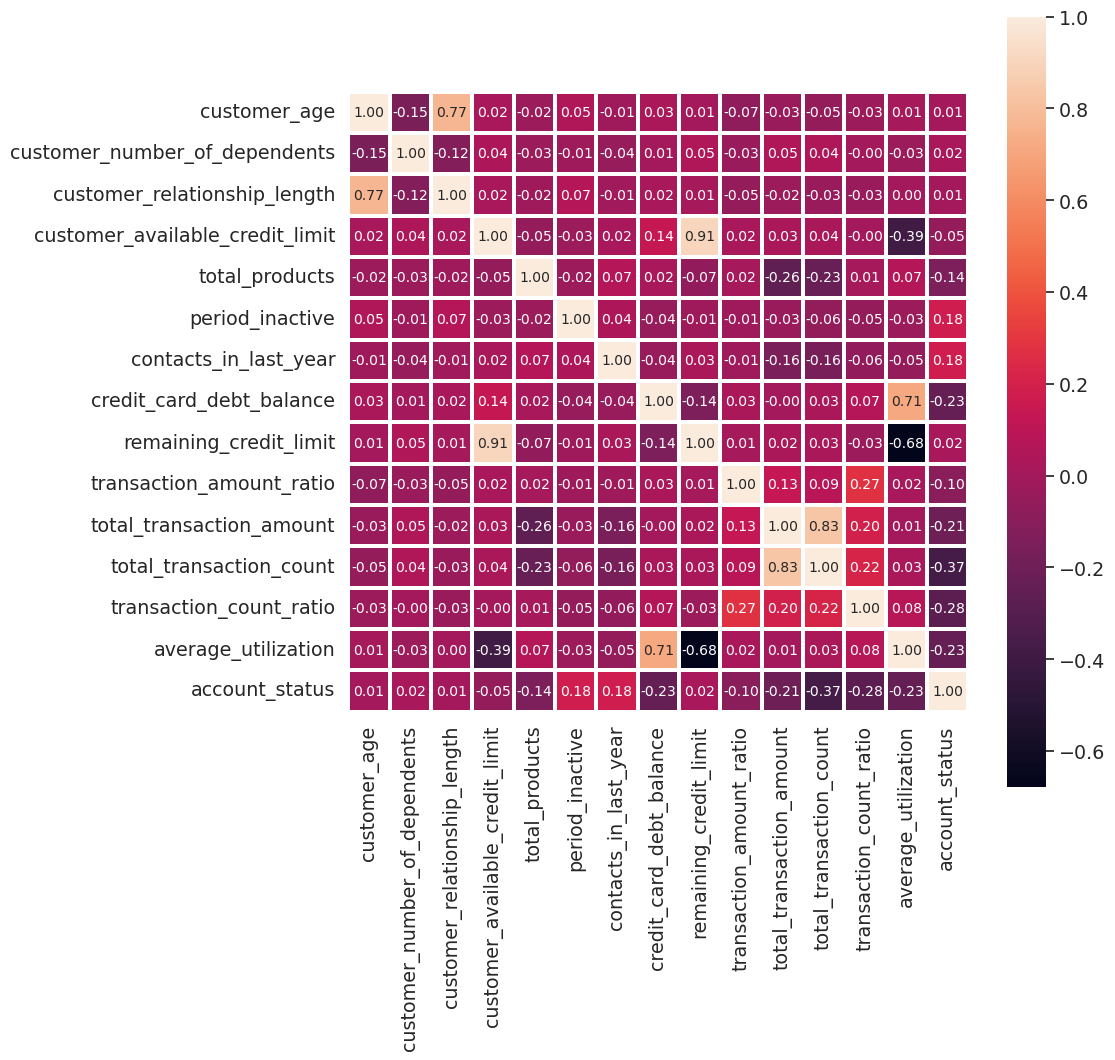

In [14]:
corr_heatmap(train_df)

High correlation detected between:
* <b>'customer_available_credit_limit'</b> ---------------> <b>'remaining_credit_limit'</b>
* <b>'credit_card_debt_balance'</b> ---------------> <b>'average_utilization'</b>
* <b>'remaining_credit_limit'</b> ---------------> <b>'average_utilization'</b>
* <b>'customer_age'</b> ---------------> <b>'relationship_length'</b>
* <b>'total_transaction_count'</b> ---------------> <b>'total_transaction_amount'</b>

## Preprocessing

### Data imputation

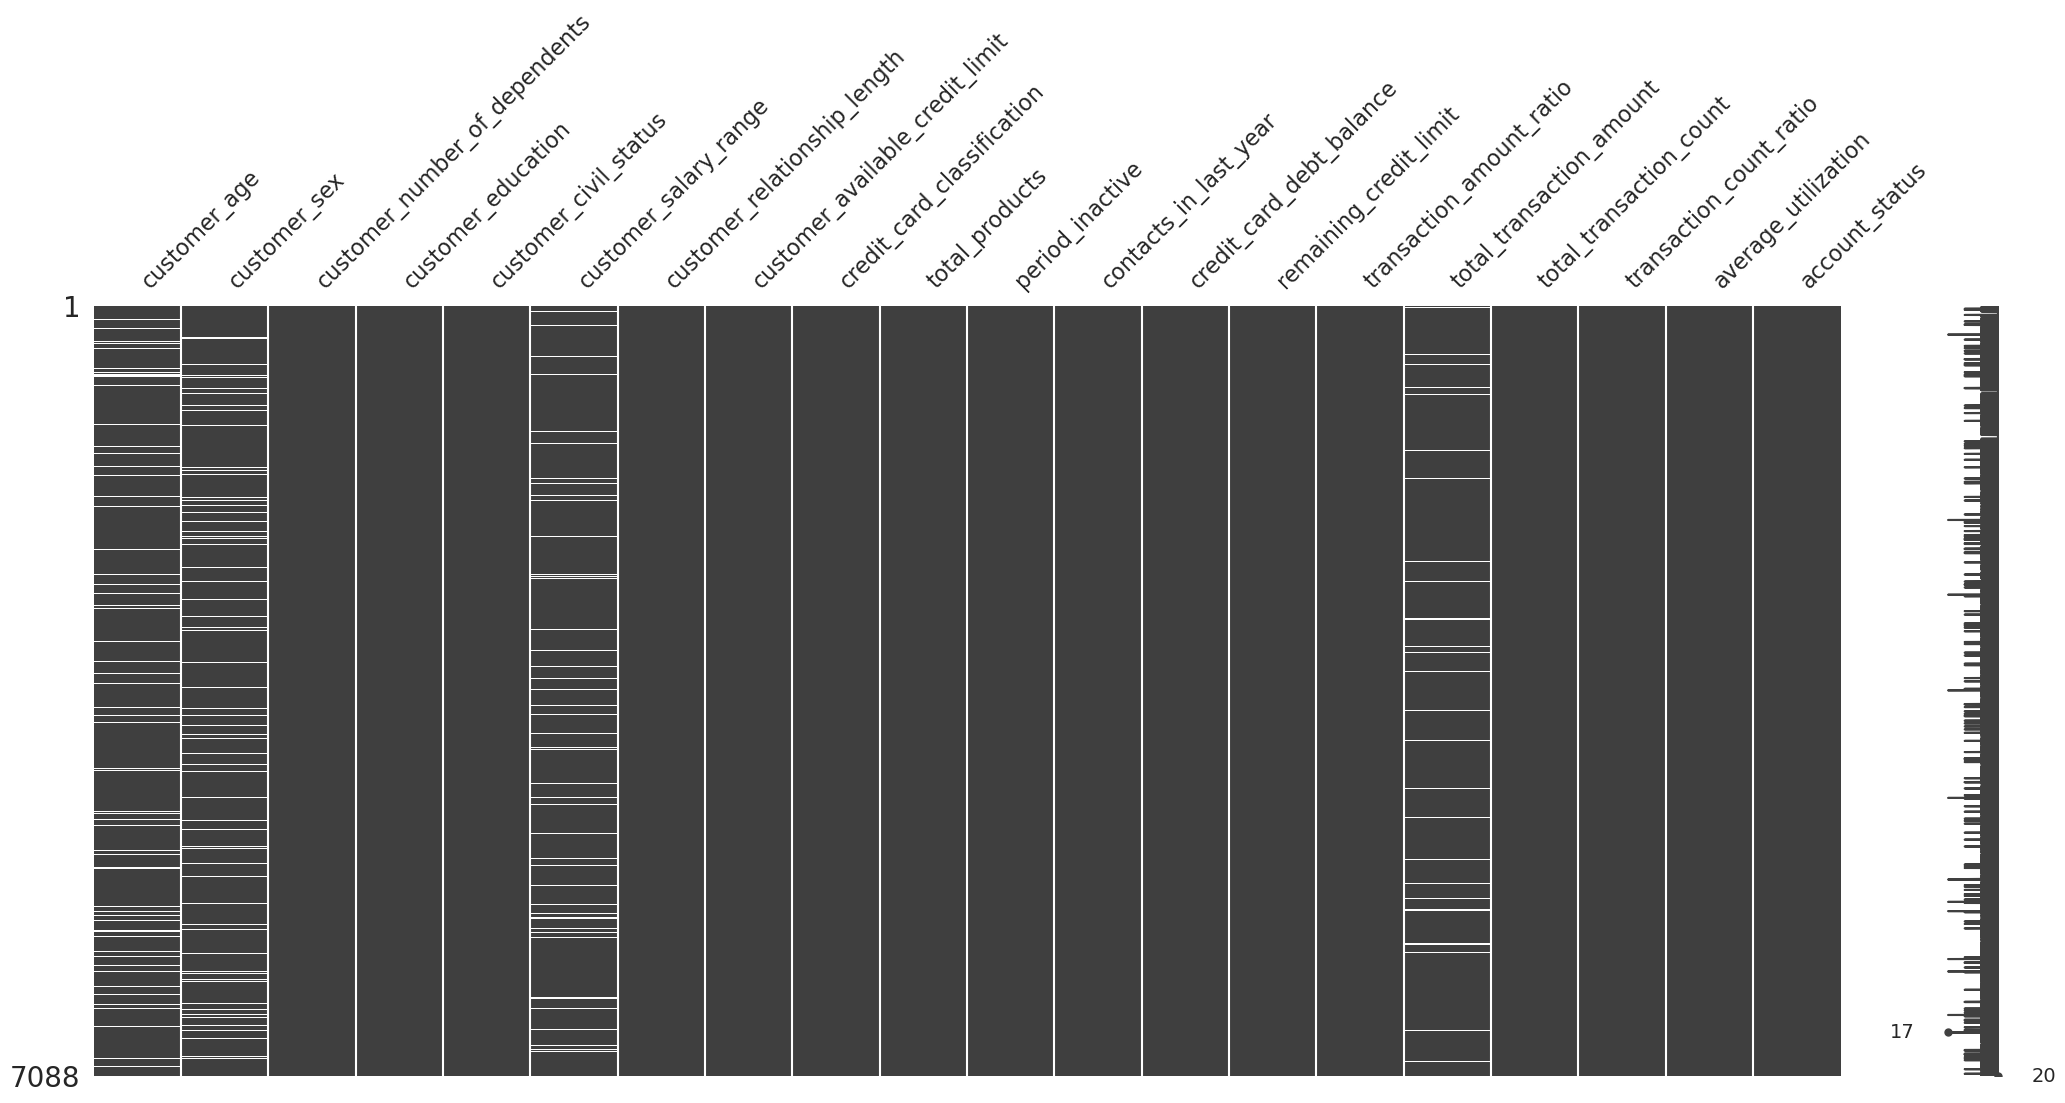

In [15]:
msno.matrix(train_df)
plt.show()

In [101]:
def chi2_test_na(df, feature1, feature2):   
    contingency_tab = pd.crosstab(index = df[feature1].isna(), columns = df[feature2])
    chi2_result = stats.chi2_contingency(contingency_tab)
    print(f"\nChi Square Test result between {feature1} and {feature2} variables.")
    print(chi2_result.pvalue)

In [ ]:
for col in ['customer_education', 'customer_salary_range', 'customer_civil_status', 'credit_card_classification', 'account_status']:
    chi2_test_na(train_df, 'customer_sex', col)

In [103]:
for col in ['customer_education', 'customer_sex', 'customer_civil_status', 'credit_card_classification', 'account_status']:
    chi2_test_na(train_df, 'customer_salary_range', col)


Chi Square Test result between customer_salary_range and customer_education variables.
0.13665423598972787

Chi Square Test result between customer_salary_range and customer_sex variables.
0.6877803458492182

Chi Square Test result between customer_salary_range and customer_civil_status variables.
0.5878619547218793

Chi Square Test result between customer_salary_range and credit_card_classification variables.
0.4585810424547847

Chi Square Test result between customer_salary_range and account_status variables.
0.5612990375033684


## Modeling

In [9]:
features_train = train_df.drop(['account_status'], axis = 1)
target_train = train_df['account_status']

In [10]:
features_test = val_df.drop(['account_status'], axis = 1)
target_test = val_df['account_status']

### Cross validation and hyperparameter optimization with Optuna

The transformations I will use in most models.

In [11]:
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='indicator', handle_missing='indicator'),
     ['customer_salary_range', 
      'customer_education',
      'customer_civil_status',
      'customer_sex',
      'credit_card_classification'
      ]),
      ('num_imputer', SimpleImputer(strategy='mean'), 
      ['total_transaction_amount']),
      ('cat_imputer', SimpleImputer(strategy='most_frequent'),
       ['customer_age'])
    ],
    remainder='passthrough')

#### Logistic Regression

In [244]:
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    
    params = dict(
        tol = trial.suggest_loguniform('tol', 1e-6 , 1e-3),
        C = trial.suggest_loguniform("C", 1e-2, 1),
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2']),
        solver = trial.suggest_categorical('solver', ['liblinear']),
        class_weight = trial.suggest_categorical('class_weight', ['balanced', None]),
        n_jobs = -1
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)

    lr_model = LogisticRegression(**params, random_state=1)

    fs = SelectFromModel(lr_model, threshold=1e-3)

    metric = 'balanced_accuracy'
    
    inner_pipe = imblearn.pipeline.Pipeline([('preprocessing', ct),
                                             ('tomek', resample),
                                             ('scaler', StandardScaler()),
                                             ('feature_select', fs),
                                             ('model', lr_model)])
    
    score = np.mean(cross_val_score(inner_pipe, features_train, target_train, cv=cv, scoring=metric))

    return score

study = opt.create_study(direction='maximize', study_name='lr', pruner=opt.pruners.HyperbandPruner())

study.optimize(objective, n_trials=100)

print('Best hyperparameters:', study.best_params)
print('Score on validation:', study.best_value)

[I 2023-06-10 17:52:19,860] A new study created in memory with name: lr
[I 2023-06-10 17:52:23,278] Trial 0 finished with value: 0.8039007688637578 and parameters: {'tol': 5.814387927450407e-06, 'C': 0.20651614708521882, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8039007688637578.
[I 2023-06-10 17:52:26,524] Trial 1 finished with value: 0.8070085352393889 and parameters: {'tol': 2.40901643980928e-06, 'C': 0.056848168462991615, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}. Best is trial 1 with value: 0.8070085352393889.
[I 2023-06-10 17:52:34,276] Trial 2 finished with value: 0.8037142732128659 and parameters: {'tol': 7.2702834592912e-06, 'C': 0.7380268496959383, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8070085352393889.
[I 2023-06-10 17:52:40,072] Trial 3 finished with value: 0.8055332783407415 and parameters: {'tol': 6.804268162609945e-06, 'C': 0.599286001

Best hyperparameters: {'tol': 1.6369116149847094e-05, 'C': 0.02264126522859723, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}
Score on validation: 0.8071493622127306


In [245]:
lr_parameters = study.best_params

In [246]:
print(lr_parameters)

{'tol': 1.6369116149847094e-05, 'C': 0.02264126522859723, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}


In [14]:
#lr_model = LogisticRegression(**lr_parameters, n_jobs=-1, random_state=1)

lr_model = LogisticRegression(**{'tol': 1.6369116149847094e-05, 'C': 0.02264126522859723, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}, 
                              random_state=1)

resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)

fs = SelectFromModel(lr_model, threshold=1e-3)

opt_lr = imblearn.pipeline.Pipeline([('preprocessing', ct),
                                     ('tomek', resample),
                                     ('scaler', StandardScaler()),
                                     ('feature_select', fs),
                                     ('model', lr_model)])

In [15]:
cv_testing = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
preval_score = np.mean(cross_val_score(opt_lr, features_train, target_train, cv=cv_testing, scoring='balanced_accuracy'))

In [16]:
print(f"Average balanced accuracy score on stratified K-fold: {round(preval_score, 3)}")

Average balanced accuracy score on stratified K-fold: 0.807


In [17]:
opt_lr.fit(features_train, target_train)
opt_preds_test = opt_lr.predict(features_test)

In [18]:
print(f'''
Logistic regression scores on validation set:
Balanced accuracy: {round(balanced_accuracy_score(target_test, opt_preds_test), 3)}
Average precision: {average_precision_score(target_test, opt_preds_test)}
F1-Score: {f1_score(target_test, opt_preds_test)}
''')


Logistic regression scores on validation set:
Balanced accuracy: 0.815
Average precision: 0.3936207175570048
F1-Score: 0.5760792639773531



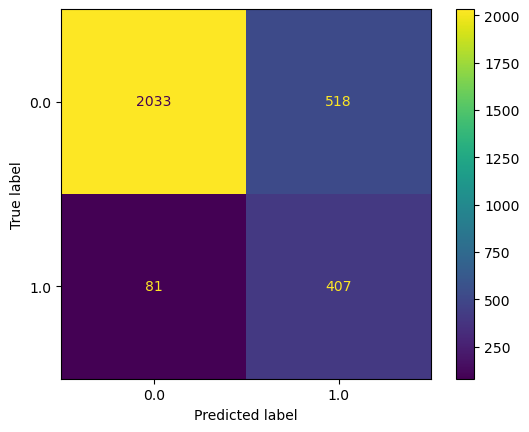

In [254]:
# Confusion matrix
conf_matrix = confusion_matrix(target_test, opt_preds_test, labels=opt_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=opt_lr.classes_)
disp.plot()
plt.grid(False)
plt.show()

#### ElasticNet

In [259]:
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    
    params = dict(
        tol = trial.suggest_loguniform('tol', 1e-6 , 1e-3),
        C = trial.suggest_loguniform("C", 1e-3, 1),
        l1_ratio = trial.suggest_loguniform("l1_ratio", 1e-6, 1),
        penalty = trial.suggest_categorical('penalty', ['elasticnet']),
        solver = trial.suggest_categorical('solver', ['saga']),
        class_weight = trial.suggest_categorical('class_weight', ['balanced', None]),
        n_jobs = -1
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)

    elastic_model = LogisticRegression(**params, random_state=1)

    fs = SelectFromModel(elastic_model, threshold=1e-3)

    metric = 'balanced_accuracy'
    
    inner_pipe = imblearn.pipeline.Pipeline([('preprocessing', ct),
                                             ('tomek', resample),
                                             ('scaler', StandardScaler()),
                                             ('feature_select', fs),
                                             ('model', elastic_model)])
    
    score = np.mean(cross_val_score(inner_pipe, features_train, target_train, cv=cv, scoring=metric))

    return score

study = opt.create_study(direction='maximize', study_name='elastic', pruner=opt.pruners.HyperbandPruner())

study.optimize(objective, n_trials=100)

print('Best hyperparameters:', study.best_params)
print('Score on validation:', study.best_value)

[I 2023-06-10 18:02:59,771] A new study created in memory with name: elastic
[I 2023-06-10 18:03:04,977] Trial 0 finished with value: 0.800177345678885 and parameters: {'tol': 3.18422449319009e-06, 'C': 0.004539757868533591, 'l1_ratio': 0.001030614726212954, 'penalty': 'elasticnet', 'solver': 'saga', 'class_weight': None}. Best is trial 0 with value: 0.800177345678885.
[I 2023-06-10 18:03:10,125] Trial 1 finished with value: 0.8038166645744391 and parameters: {'tol': 4.183968405504709e-06, 'C': 0.02195728695170616, 'l1_ratio': 1.7122097860196525e-06, 'penalty': 'elasticnet', 'solver': 'saga', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8038166645744391.
/home/maciej/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/maciej/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_

Best hyperparameters: {'tol': 1.2722640579076221e-05, 'C': 0.022828183010196526, 'l1_ratio': 0.9831655046929327, 'penalty': 'elasticnet', 'solver': 'saga', 'class_weight': None}
Score on validation: 0.8069920389585208


In [261]:
elastic_parameters = study.best_params

In [262]:
elastic_parameters

{'tol': 1.2722640579076221e-05,
 'C': 0.022828183010196526,
 'l1_ratio': 0.9831655046929327,
 'penalty': 'elasticnet',
 'solver': 'saga',
 'class_weight': None}

In [19]:
#elastic_model = LogisticRegression(**lr_parameters, n_jobs=-1, random_state=1)

elastic_model = LogisticRegression(**{'tol': 1.2722640579076221e-05, 'C': 0.022828183010196526, 'l1_ratio': 0.9831655046929327, 
                                      'penalty': 'elasticnet', 'solver': 'saga', 'class_weight': None}, n_jobs=-1, random_state=1)

resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)

fs = SelectFromModel(elastic_model, threshold=1e-3)

opt_elastic = imblearn.pipeline.Pipeline([('preprocessing', ct),
                                     ('tomek', resample),
                                     ('scaler', StandardScaler()),
                                     ('feature_select', fs),
                                     ('model', elastic_model)])

In [20]:
cv_testing = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
preval_score = np.mean(cross_val_score(opt_elastic, features_train, target_train, cv=cv_testing, scoring='balanced_accuracy'))

In [21]:
print(f"Average balanced accuracy score on stratified K-fold: {round(preval_score, 3)}")

Average balanced accuracy score on stratified K-fold: 0.807


In [22]:
opt_elastic.fit(features_train, target_train)
opt_preds_test = opt_elastic.predict(features_test)

In [23]:
print(f'''
Logistic regression scores on validation set:
Balanced accuracy: {round(balanced_accuracy_score(target_test, opt_preds_test), 3)}
Average precision: {average_precision_score(target_test, opt_preds_test)}
F1-Score: {f1_score(target_test, opt_preds_test)}
''')


Logistic regression scores on validation set:
Balanced accuracy: 0.816
Average precision: 0.39707707581561974
F1-Score: 0.5798138869005011



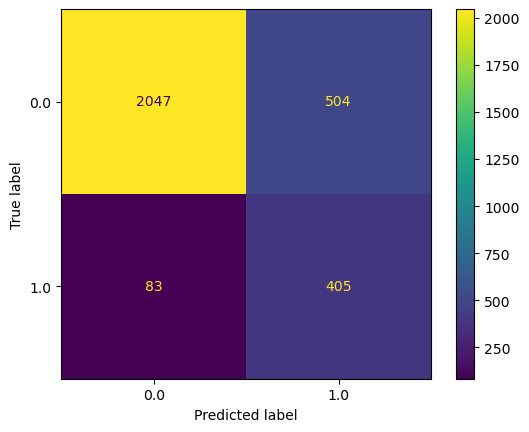

In [271]:
# Confusion matrix
conf_matrix = confusion_matrix(target_test, opt_preds_test, labels=opt_elastic.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=opt_elastic.classes_)
disp.plot()
plt.grid(False)
plt.show()

#### KNeighbours

In [44]:
knn_features = features_train[['total_products', 'period_inactive', 
                               'contacts_in_last_year', 'credit_card_debt_balance', 
                               'transaction_amount_ratio','total_transaction_amount',
                               'total_transaction_count', 'average_utilization',
                               'customer_sex', 'customer_salary_range',
                               'customer_civil_status', 'customer_education']]

knn_ct = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='indicator', handle_missing='indicator'),
     ['customer_salary_range', 
      'customer_education',
      'customer_civil_status',
      'customer_sex'
      ]),
      ('num_imputer', SimpleImputer(strategy='mean'), 
      ['total_transaction_amount'])
    ],
    remainder='passthrough')

In [51]:
import warnings
warnings.filterwarnings('ignore')

opt.logging.set_verbosity(opt.logging.INFO)

def objective(trial):
    
    params = dict(
        n_neighbors = trial.suggest_int("n_neighbors", 20, 100),
        weights = trial.suggest_categorical("weights", ['uniform', 'distance']),
        metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        n_jobs = -1
    )

    resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)
    
    knn_model = KNeighborsClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    metric = 'balanced_accuracy'

    pipe = imblearn.pipeline.Pipeline([('preprocessing', knn_ct),
                                       ('tomek', resample),
                                       ('scaler', StandardScaler()),
                                       ('model', knn_model)])
    
    score = np.mean(cross_val_score(pipe, knn_features, target_train, cv=cv, scoring=metric))

    return score

study = opt.create_study(direction='maximize', study_name='knn', pruner=opt.pruners.HyperbandPruner())

study.optimize(objective, n_trials=100)

print('Best hyperparameters:', study.best_params)
print('Score on validation:', study.best_value)

[I 2023-06-10 19:47:24,578] A new study created in memory with name: knn
[I 2023-06-10 19:47:28,111] Trial 0 finished with value: 0.6954041380892645 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.6954041380892645.
[I 2023-06-10 19:47:31,771] Trial 1 finished with value: 0.6974849271164191 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.6974849271164191.
[I 2023-06-10 19:47:35,491] Trial 2 finished with value: 0.6872603423616324 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.6974849271164191.
[I 2023-06-10 19:47:39,049] Trial 3 finished with value: 0.7121070961969466 and parameters: {'n_neighbors': 74, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 3 with value: 0.7121070961969466.
[I 2023-06-10 19:47:43,048] Trial 4 finished with value: 0.7002273824302025 and parameters: {'n_neighb

Best hyperparameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'euclidean'}
Score on validation: 0.7536663397037662


In [52]:
knn_parameters = study.best_params

In [53]:
print(knn_parameters)

{'n_neighbors': 88, 'weights': 'distance', 'metric': 'euclidean'}


In [54]:
#knn_model = KNeighbourClassifier(**knn_parameters, n_jobs=-1, random_state=1)

knn_model = KNeighborsClassifier(**{'n_neighbors': 88, 'weights': 'distance', 'metric': 'minkowski'}, n_jobs=-1)

resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)

#fs = SelectFromModel(knn_model, threshold=1e-3)

opt_knn = imblearn.pipeline.Pipeline([('preprocessing', knn_ct),
                                      ('tomek', resample),
                                      ('scaler', StandardScaler()),
                                      #('feature_select', fs),
                                      ('model', knn_model)])

In [55]:
cv_testing = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
preval_score = np.mean(cross_val_score(opt_knn, knn_features, target_train, cv=cv_testing, scoring='balanced_accuracy'))

In [56]:
print(f"Average balanced accuracy score on stratified K-fold: {round(preval_score, 3)}")

Average balanced accuracy score on stratified K-fold: 0.754


In [57]:
opt_knn.fit(knn_features, target_train)
opt_preds_test = opt_knn.predict(features_test[['total_products', 'period_inactive', 
                               'contacts_in_last_year', 'credit_card_debt_balance', 
                               'transaction_amount_ratio','total_transaction_amount',
                               'total_transaction_count', 'average_utilization',
                               'customer_sex', 'customer_salary_range',
                               'customer_civil_status', 'customer_education']])

In [58]:
print(f'''
KNeighbors scores on validation set:
Balanced accuracy: {round(balanced_accuracy_score(target_test, opt_preds_test), 3)}
Average precision: {average_precision_score(target_test, opt_preds_test)}
F1-Score: {f1_score(target_test, opt_preds_test)}
''')


KNeighbors scores on validation set:
Balanced accuracy: 0.738
Average precision: 0.2999577302589285
F1-Score: 0.474308300395257



In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(target_test, opt_preds_test, labels=opt_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=opt_knn.classes_)
disp.plot()
plt.grid(False)
plt.show()

#### Random Forest

In [316]:
import warnings
warnings.filterwarnings('ignore')

opt.logging.set_verbosity(opt.logging.WARNING)

def objective(trial):
    
    params = dict(
        n_estimators = trial.suggest_int("n_estimators", 100, 1000),
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        max_depth = trial.suggest_int('max_depth', 2, 10),
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        n_jobs = -1
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)

    rf_model = RandomForestClassifier(**params, random_state=1)

    fs = SelectFromModel(rf_model, threshold=1e-3)

    metric = 'balanced_accuracy'
    
    pipe = imblearn.pipeline.Pipeline([('preprocessing', ct),
                                       ('tomek', resample),
                                       ('feature_select', fs),
                                       ('model', rf_model)])
    
    score = np.mean(cross_val_score(pipe, features_train, target_train, cv=cv, scoring=metric))

    return score

study = opt.create_study(direction='maximize', study_name='rf', pruner=opt.pruners.HyperbandPruner())

study.optimize(objective, n_trials=20)

print('Best hyperparameters:', study.best_params)
print('Score on validation:', study.best_value)

Best hyperparameters: {'n_estimators': 675, 'criterion': 'entropy', 'max_depth': 9, 'max_features': None}
Score on validation: 0.9222917664777661


In [317]:
rf_parameters = study.best_params

In [318]:
print(rf_parameters)

{'n_estimators': 675, 'criterion': 'entropy', 'max_depth': 9, 'max_features': None}


In [24]:
#model = RandomForestClassifier(**rf_parameters, n_jobs=-1, random_state=1)

rf_model = RandomForestClassifier(**{'n_estimators': 675,
                                     'criterion': 'entropy',
                                     'max_depth': 9,
                                     'max_features': None}, n_jobs=-1, random_state=1)


resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)

fs = SelectFromModel(rf_model, threshold=1e-3)

opt_rf = imblearn.pipeline.Pipeline([('preprocessing', ct),
                                      ('tomek', resample),
                                      ('feature_select', fs),
                                      ('model', rf_model)])

In [25]:
cv_testing = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
preval_score = np.mean(cross_val_score(opt_rf, features_train, target_train, cv=cv_testing, scoring='balanced_accuracy'))

In [26]:
print(f"Average balanced accuracy score on stratified K-fold: {round(preval_score, 3)}")

Average balanced accuracy score on stratified K-fold: 0.922


In [27]:
opt_rf.fit(features_train, target_train)
opt_preds_test = opt_rf.predict(features_test)

In [28]:
print(f'''
Random Forest scores on validation set:
Balanced accuracy: {round(balanced_accuracy_score(target_test, opt_preds_test), 3)}
Average precision: {average_precision_score(target_test, opt_preds_test)}
F1-Score: {f1_score(target_test, opt_preds_test)}
''')


Random Forest scores on validation set:
Balanced accuracy: 0.924
Average precision: 0.7338643829913069
F1-Score: 0.8451801363193768



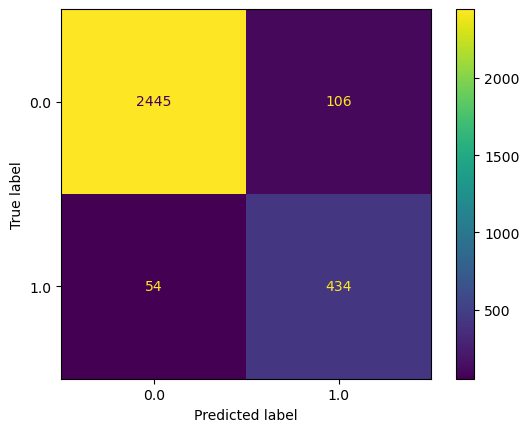

In [24]:
# Confusion matrix
conf_matrix = confusion_matrix(target_test, opt_preds_test, labels=opt_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=opt_rf.classes_)
disp.plot()
plt.grid(False)
plt.show()

Which features were chosen?

In [25]:
print(f"Number of features going in: {opt_rf['feature_select'].n_features_in_}")
print(f"Number of features going out: {opt_rf['model'].n_features_in_}")

Number of features going in: 42
Number of features going out: 26


#### Xgboost

In [292]:
def objective(trial):
    
    params = dict(
        n_estimators = trial.suggest_int("n_estimators", 100, 1000),
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0),
        gamma = trial.suggest_float('gamma', 0.01, 1.0),
        max_depth = trial.suggest_int('max_depth', 2, 10),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        subsample = trial.suggest_float('subsample', 0.01, 1.0),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1.0),
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 1.0),
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 1.0),
        n_jobs = -1
    )
    
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    inner_resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)

    inner_model = xgb.XGBClassifier(**params, random_state=1)

    inner_fs = SelectFromModel(inner_model, threshold=1e-3)

    metric = 'balanced_accuracy'
    
    inner_pipe = imblearn.pipeline.Pipeline([('preprocessing', ct),
                                          ('tomek', inner_resample),
                                          ('feature_select', inner_fs),
                                          ('model', inner_model)])
    
    score = np.mean(cross_val_score(inner_pipe, X_train, y_train, cv=cv_inner, scoring=metric))

    return score

In [293]:
import warnings
warnings.filterwarnings('ignore')

opt.logging.set_verbosity(opt.logging.WARNING)

outer_results = []

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for train_ix, val_ix in cv_outer.split(features_train, target_train):
    
    X_train, X_val = train_df.iloc[train_ix, :], train_df.iloc[val_ix, :]

    y_train, y_val = X_train['account_status'], X_val['account_status']

    X_train = X_train.drop(columns=['account_status'], axis = 1)

    X_val = X_val.drop(columns=['account_status'], axis = 1)

    study = opt.create_study(direction='maximize', study_name='xgb', pruner=opt.pruners.HyperbandPruner(), sampler=opt.samplers.TPESampler(seed=1))

    study.optimize(objective, n_trials=100)

    outer_resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)
    
    outer_model = xgb.XGBClassifier(**study.best_params, n_jobs=-1, random_state=1)

    outer_fs = SelectFromModel(outer_model, threshold=1e-3)

    outer_pipe = imblearn.pipeline.Pipeline([('preprocessing', ct),
                                          ('tomek', outer_resample),
                                          ('feature_select', outer_fs),
                                          ('model', outer_model)])

    outer_pipe.fit(X_train, y_train)

    outer_preds = outer_pipe.predict(X_val)

    outer_score = balanced_accuracy_score(y_val, outer_preds)

    outer_results.append((study.best_params, outer_score))

    print('Best hyperparameters:', study.best_params)
    print('Score on validation:', outer_score)

Best hyperparameters: {'n_estimators': 659, 'learning_rate': 0.10915775165824755, 'gamma': 0.5152660120270364, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9005137474884025, 'colsample_bytree': 0.7898385021344859, 'reg_alpha': 0.06691457705292025, 'reg_lambda': 0.35522238240406356}
Score on validation: 0.9258071649712516
Best hyperparameters: {'n_estimators': 842, 'learning_rate': 0.08886193391650485, 'gamma': 0.740195785753426, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.9713799257380391, 'colsample_bytree': 0.812177635523945, 'reg_alpha': 0.15164102220151515, 'reg_lambda': 0.28875962886297907}
Score on validation: 0.9319659442724457
Best hyperparameters: {'n_estimators': 866, 'learning_rate': 0.15678730163093, 'gamma': 0.73673199738917, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9157365444784694, 'colsample_bytree': 0.8584699953374716, 'reg_alpha': 0.9692267696309382, 'reg_lambda': 0.219113411222258}
Score on validation: 0.9181519976411617
Best hyperpara

In [294]:
xgb_parameters = max(outer_results, key=lambda item: item[1])[0]

In [295]:
print(xgb_parameters)

{'n_estimators': 100, 'learning_rate': 0.16474046382972407, 'gamma': 0.5124082846922701, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8075185211385638, 'colsample_bytree': 0.7511935269307113, 'reg_alpha': 0.8418473994077464, 'reg_lambda': 0.4909430329081276}


In [29]:
#xgb_model = xgb.XGBClassifier(**xgb_parameters, n_jobs=-1, random_state=1)

xgb_model = xgb.XGBClassifier(**{'n_estimators': 100, 
                                 'learning_rate': 0.16474046382972407, 
                                 'gamma': 0.5124082846922701, 
                                 'max_depth': 10, 
                                 'min_child_weight': 2, 
                                 'subsample': 0.8075185211385638, 
                                 'colsample_bytree': 0.7511935269307113, 
                                 'reg_alpha': 0.8418473994077464, 
                                 'reg_lambda': 0.4909430329081276}, n_jobs=-1, random_state=1)

resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)

fs = SelectFromModel(xgb_model, threshold=1e-2)

opt_xgb = imblearn.pipeline.Pipeline([('preprocessing', ct),
                                      ('tomek', resample),
                                      ('feature_select', fs),
                                      ('model', xgb_model)])

In [30]:
cv_testing = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
preval_score = np.mean(cross_val_score(opt_xgb, features_train, target_train, cv=cv_testing, scoring='balanced_accuracy'))

In [363]:
print(f"Average balanced accuracy score on stratified K-fold: {round(preval_score, 3)}")

Average balanced accuracy score on stratified K-fold: 0.933


In [31]:
opt_xgb.fit(features_train, target_train)
opt_preds_test = opt_xgb.predict(features_test)

print(f'''
XGBoost scores on validation set:
Balanced accuracy: {round(balanced_accuracy_score(target_test, opt_preds_test), 3)}
Average precision: {average_precision_score(target_test, opt_preds_test)}
F1-Score: {f1_score(target_test, opt_preds_test)}
''')


XGBoost scores on validation set:
Balanced accuracy: 0.934
Average precision: 0.8168481011744002
F1-Score: 0.8937048503611972



##### Different encoders and gain on SMOTE

In [335]:
cat_ct = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='indicator', handle_missing='indicator'),
     ['customer_salary_range', 
      'customer_education',
      'customer_civil_status',
      'customer_sex',
      ]),
      ('cat_encoder', CatBoostEncoder(random_state=1, handle_missing='value', handle_unknown='value'),
      ['credit_card_classification']),
      ('num_imputer', SimpleImputer(strategy='mean'), 
      ['total_transaction_amount']),
      ('cat_imputer', SimpleImputer(strategy='most_frequent'),
       ['customer_age'])
    ],
    remainder='passthrough')

xgb_model = xgb.XGBClassifier(**{'n_estimators': 100, 
                                 'learning_rate': 0.16474046382972407, 
                                 'gamma': 0.5124082846922701, 
                                 'max_depth': 10, 
                                 'min_child_weight': 2, 
                                 'subsample': 0.8075185211385638, 
                                 'colsample_bytree': 0.7511935269307113, 
                                 'reg_alpha': 0.8418473994077464, 
                                 'reg_lambda': 0.4909430329081276}, n_jobs=-1, random_state=1)

resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)

fs = SelectFromModel(xgb_model, threshold=1e-2)

cat_opt_xgb = imblearn.pipeline.Pipeline([('preprocessing', cat_ct),
                                      ('tomek', resample),
                                      ('feature_select', fs),
                                      ('model', xgb_model)])

In [336]:
catboost_score = np.mean(cross_val_score(cat_opt_xgb, features_train, target_train, cv=cv_testing, scoring='balanced_accuracy'))

In [337]:
xgb_model = xgb.XGBClassifier(**{'n_estimators': 100, 
                                 'learning_rate': 0.16474046382972407, 
                                 'gamma': 0.5124082846922701, 
                                 'max_depth': 10, 
                                 'min_child_weight': 2, 
                                 'subsample': 0.8075185211385638, 
                                 'colsample_bytree': 0.7511935269307113, 
                                 'reg_alpha': 0.8418473994077464, 
                                 'reg_lambda': 0.4909430329081276}, n_jobs=-1, random_state=1)

resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)

fs = SelectFromModel(xgb_model, threshold=1e-2)

nosmote_xgb = imblearn.pipeline.Pipeline([('preprocessing', cat_ct),
                                      #('tomek', resample),
                                      ('feature_select', fs),
                                      ('model', xgb_model)])

In [338]:
nosmote_score = np.mean(cross_val_score(nosmote_xgb, features_train, target_train, cv=cv_testing, scoring='balanced_accuracy'))

In [340]:
print(f"Base score with catboost and SMOTE: {round(preval_score, 3)}")
print(f"Score with Catboost encoder: {round(catboost_score, 3)}")
print(f"Score without SMOTE: {round(nosmote_score, 3)}")

Base score with catboost and SMOTE: 0.933
Score with Catboost encoder: 0.926
Score without SMOTE: 0.921


In [341]:
cat_opt_xgb.fit(features_train, target_train)
opt_preds_test = cat_opt_xgb.predict(features_test)

In [342]:
print(f'''
XGBoost scores on validation set:
Balanced accuracy: {round(balanced_accuracy_score(target_test, opt_preds_test), 3)}
Average precision: {average_precision_score(target_test, opt_preds_test)}
F1-Score: {f1_score(target_test, opt_preds_test)}
''')


XGBoost scores on validation set:
Balanced accuracy: 0.938
Average precision: 0.81704751717895
F1-Score: 0.894575230296827



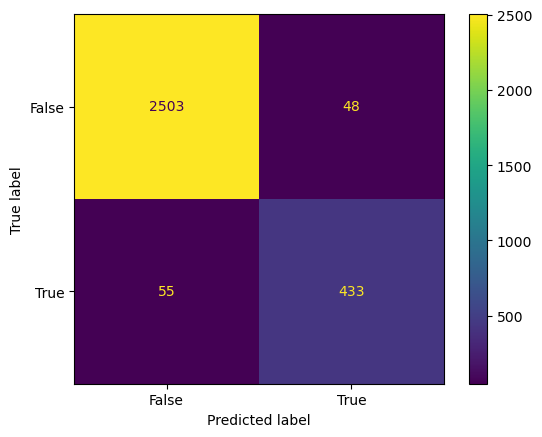

In [365]:
# Confusion matrix
conf_matrix = confusion_matrix(target_test, opt_preds_test, labels=opt_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=opt_xgb.classes_)
disp.plot()
plt.grid(False)
plt.show()

Feature importance of XGBoost - cannot use ColumnTransformer, because I want to keep feature names.

In [32]:
features_train_fs = features_train.copy()

xgb_model = xgb.XGBClassifier(**{'n_estimators': 100, 
                                 'learning_rate': 0.16474046382972407, 
                                 'gamma': 0.5124082846922701, 
                                 'max_depth': 10, 
                                 'min_child_weight': 2, 
                                 'subsample': 0.8075185211385638, 
                                 'colsample_bytree': 0.7511935269307113, 
                                 'reg_alpha': 0.8418473994077464, 
                                 'reg_lambda': 0.4909430329081276}, n_jobs=-1, random_state=1)

onehot_enc = OneHotEncoder(cols=['customer_salary_range',
                                 'customer_education',
                                 'customer_civil_status',
                                 'customer_sex',
                                 'credit_card_classification'
                                 ],
                           handle_unknown='indicator', 
                           handle_missing='indicator',
                           use_cat_names=True)

features_train_fs = onehot_enc.fit_transform(features_train_fs)

features_train_fs['total_transaction_amount'].fillna(features_train_fs['total_transaction_amount'].mean(), inplace=True)

features_train_fs['customer_age'].fillna(features_train_fs['customer_age'].mode()[0], inplace=True)

resample = imblearn.combine.SMOTETomek(tomek=imblearn.under_sampling.TomekLinks(sampling_strategy='majority'), random_state = 1)

fs = SelectFromModel(xgb_model, threshold=1e-2)

features_train_fs, target_train_fs = resample.fit_resample(features_train_fs, target_train)

saved_cols = features_train_fs.columns

features_train_fs = fs.fit_transform(features_train_fs, target_train_fs)

In [33]:
features_train_fs = pd.DataFrame(features_train_fs, columns=saved_cols[fs.get_support()])

In [35]:
xgb_model.fit(features_train_fs, target_train_fs)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7511935269307113, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5124082846922701, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.16474046382972407, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

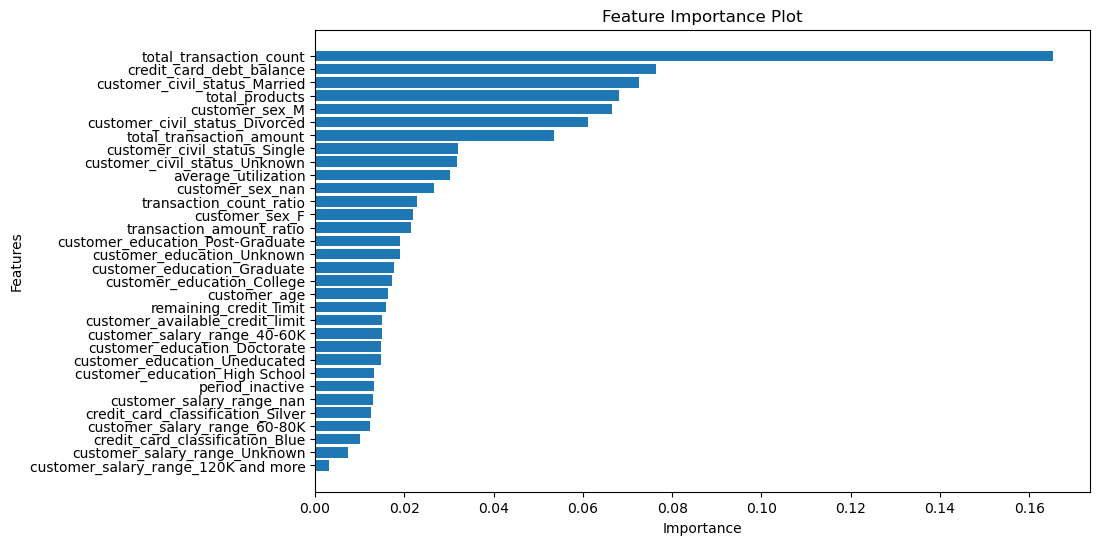

In [37]:
importance = xgb_model.feature_importances_
feature_names = list(saved_cols[fs.get_support()])

sorted_importance, sorted_feature_names = zip(*sorted(zip(importance, feature_names), reverse=False))

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

In [390]:
print(f"Before feature selection: {fs.n_features_in_}")
print(f"After feature selection: {len(feature_names)}")

Before feature selection: 47
After feature selection: 32


In [372]:
xgb_model.get_booster().feature_names = list(saved_cols[fs.get_support()])

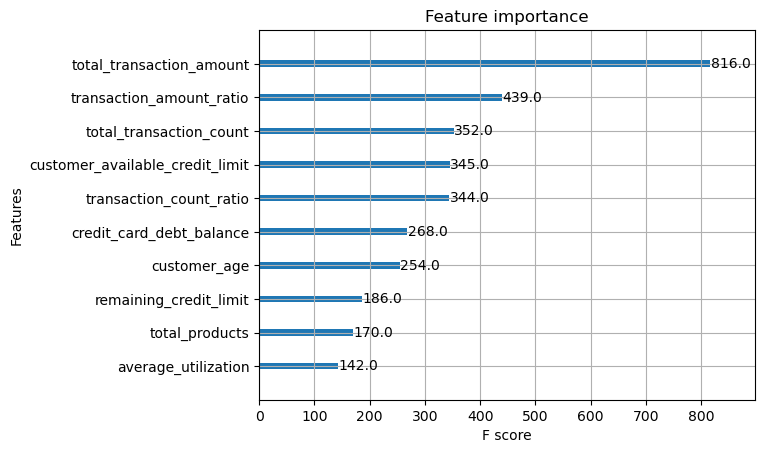

In [373]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()